In [43]:
import pandas as pd
import numpy as np
import re
import csv
import urllib.request
from io import StringIO
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, f1_score

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def read_tweet_data(url_link):
  response = urllib.request.urlopen(url_link)
  csv_data = response.read().decode('utf-8')
  # Use csv.reader to read the CSV data
  csv_reader = csv.reader(StringIO(csv_data))
  # Extract header and data separately
  header = next(csv_reader)
  data = [row for row in csv_reader]
  # Create a DataFrame from the data
  dataset = pd.DataFrame(data, columns=header)
  return dataset

In [33]:
df_train = read_tweet_data('https://github.com/K-a-m-o/Classification-Predict/raw/main/train.csv')

In [34]:
df_test= pd.read_csv('test_with_no_labels.csv')

# Explore the Data

In [35]:
df_train.describe()

,sentiment,message,tweetid
count,15819,15819,15819
unique,4,14229,15819
top,1,RT @StephenSchlegel: she's thinking about how ...,625221
freq,8530,307,1


In [7]:
df_test.describe()

,tweetid
count,10546.000000
mean,496899.936943
std,288115.677148
min,231.000000
25%,246162.500000
50%,495923.000000
75%,742250.000000
max,999983.000000


In [8]:
df_train.isnull().any()
df_test.isnull().any()

message    False
tweetid    False
dtype: bool

Looking at how many null values we have in our dataset and we derive that there is no null values

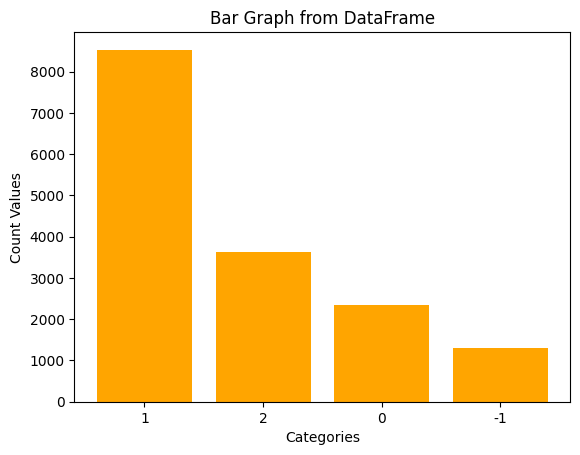

In [9]:
plt.bar(df_train['sentiment'].value_counts().index.astype('str'), df_train['sentiment'].value_counts(), color='orange')

plt.xlabel('Categories')
plt.ylabel('Count Values')
plt.title('Bar Graph from DataFrame')

# Display the plot
plt.show()

From this we can see that our data points fall mostly on the sentiment 1 whith over 8000 values in our train dataset, our model might be biased as there is more training data for this Sentiment and we mght need to balance

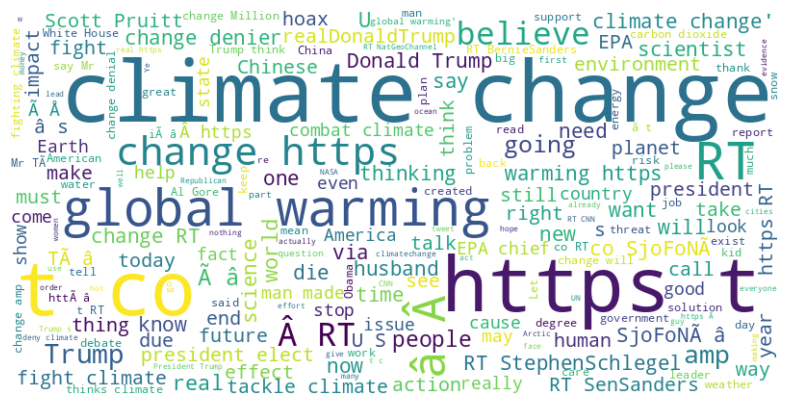

In [10]:
# Assuming 'message' is the column containing text data in the DataFrame
text_data = ' '.join(df_train['message'].dropna())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

From this we can see the most occuring words are https, climate, global, warming and w see a lot of single charactors which do not add meaning for modeling. Will look at how we can clean this data


*   Wil remove the single charactor words
*   Remove the rt which is retweets as a stopword



In [11]:
stopwords_list = stopwords.words('english')+['rt']
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In order for us to understand the data I will print all the words in a wordcloud to figure out which

# Data Pre-processsing

Lemmatisation to standardise all our words from the words net, we have some words like makeadifference, we need to standardize this so that it makes sense

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

In [14]:
def stem_text(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

I created this function preprocess text to standardise the data prep into one function so that I can run this on unseen data

In [37]:
def preprocess_text(tweet):
    # Remove URLs, mentions, and special characters
    tweet = re.sub(r'http\S+|www\S+|@[^\s]+|\W|\d', ' ', tweet)
    # Tokenize
    tokens = word_tokenize(tweet.lower())
    # Remove stop words, short words, and specific 2-letter words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    # Lemmatize
    lemmatized_tokens = lemmatize_text(tokens)
    # Stem
    # stemmed_tokens = stem_text(lemmatized_tokens)
    # Join stemmed tokens back into a sentence with whitespaces
    cleaned_tweet = ' '.join(lemmatized_tokens)
    return cleaned_tweet
df_train['cleaned_message'] = df_train['message'].apply(preprocess_text)

Creating a wordcloud to see the structure of our data

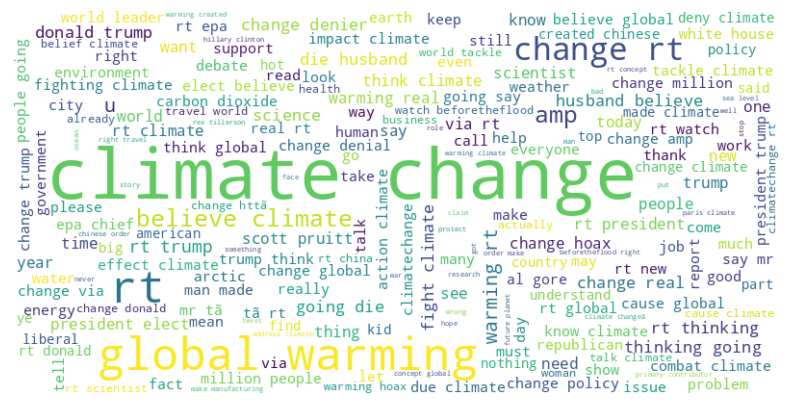

In [16]:
# Assuming 'message' is the column containing text data in the DataFrame
text_data = ' '.join(df_train['cleaned_message'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Get the word frequencies from the WordCloud object
word_frequencies = wordcloud.words_

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

Looking at the effect the text pre preparation step to see how much the data is getting cleaning but it seems like it is losing some data.
From this wordcloud we observe that there are still words like rt which may be combined with other words

In [17]:
df_train[['message', 'cleaned_message']].head()

,message,cleaned_message
0,PolySciMajor EPA chief doesn't think carbon di...,polyscimajor epa chief think carbon dioxide ma...
1,It's not like we lack evidence of anthropogeni...,like lack evidence anthropogenic global warming
2,RT @RawStory: Researchers say we have three ye...,rt researcher say three year act climate chang...
3,#TodayinMaker# WIRED : 2016 was a pivotal year...,todayinmaker wired pivotal year war climate ch...
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",rt racist sexist climate change denying bigot ...


# Model Perfomance and evaluation
In this first model I will compare different models to my cleaned data and choose the best performing model to improve

In [18]:
# Create a list of models that I will use that we learnt in class
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC()
}

Run the models against different models and recieve a classification report to choose model with the best f1 score, beacuse am working with tex data I need to vectorise

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
X_train, X_test, y_train, y_test = train_test_split(df_train['cleaned_message'], df_train['sentiment'], test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_tfidf)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print the results
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'micro', 'macro', or 'weighted'
    classification_rep = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("Classification Report:")
    print(classification_rep)

Accuracy: 0.6564475347661188
F1 Score: 0.5772775797715801
Classification Report:
              precision    recall  f1-score   support

          -1       0.80      0.01      0.03       278
           0       0.82      0.07      0.12       425
           1       0.63      0.98      0.76      1755
           2       0.86      0.47      0.61       706

    accuracy                           0.66      3164
   macro avg       0.78      0.38      0.38      3164
weighted avg       0.72      0.66      0.58      3164

Accuracy: 0.6943742098609356
F1 Score: 0.6684722965644577
Classification Report:
              precision    recall  f1-score   support

          -1       0.83      0.23      0.36       278
           0       0.57      0.33      0.41       425
           1       0.69      0.89      0.78      1755
           2       0.73      0.61      0.67       706

    accuracy                           0.69      3164
   macro avg       0.71      0.51      0.55      3164
weighted avg       0.70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7345132743362832
F1 Score: 0.716148154375124
Classification Report:
              precision    recall  f1-score   support

          -1       0.79      0.33      0.47       278
           0       0.62      0.38      0.47       425
           1       0.74      0.90      0.81      1755
           2       0.76      0.70      0.73       706

    accuracy                           0.73      3164
   macro avg       0.73      0.58      0.62      3164
weighted avg       0.73      0.73      0.72      3164

Accuracy: 0.7354614412136536
F1 Score: 0.7102509178235509
Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.30      0.45       278
           0       0.75      0.32      0.45       425
           1       0.71      0.93      0.81      1755
           2       0.80      0.68      0.73       706

    accuracy                           0.74      3164
   macro avg       0.79      0.56      0.61      3164
weighted avg       0.75 

After ecaluation w can see that the best performing model is Logistic regresssion with a score of 71,61%

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_train['cleaned_message'], df_train['sentiment'], test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize Logistic Regression model
logistic_regression_model = LogisticRegression()

# Train the Logistic Regression model
logistic_regression_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = logistic_regression_model.predict(X_test_tfidf)

# Evaluate the Logistic Regression model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print("Model: Logistic Regression")
print("Accuracy:", accuracy)
print("Classification Report:")
print(class_report)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.7345132743362832
Classification Report:
              precision    recall  f1-score   support

          -1       0.79      0.33      0.47       278
           0       0.62      0.38      0.47       425
           1       0.74      0.90      0.81      1755
           2       0.76      0.70      0.73       706

    accuracy                           0.73      3164
   macro avg       0.73      0.58      0.62      3164
weighted avg       0.73      0.73      0.72      3164



The model that is performing btter than all the other model is the Logististic Regression Model witha 73% accuracy

In [21]:
import pandas as pd

# Assuming you have already defined df_test, preprocess_text, and the trained model (e.g., logistic_regression_model)

# Apply text preprocessing to the 'message' column
df_test['cleaned_message'] = df_test['message'].apply(preprocess_text)

# Convert the cleaned text data to TF-IDF features
X_test_tfidf = tfidf_vectorizer.transform(df_test['cleaned_message'])

# Make predictions using the trained model
df_test['predicted_sentiment'] = logistic_regression_model.predict(X_test_tfidf)

# Create a DataFrame for the submission file
submission_df = pd.DataFrame({'tweetid': df_test['tweetid'], 'sentiment': df_test['predicted_sentiment']})

# Save the submission file to a CSV
submission_df.to_csv('submission_file.csv', index=False)

First submission

#Balancing the data

In [22]:
# Assuming your DataFrame df_train has columns 'sentiment' and 'cleaned_message'
X = df_train['cleaned_message']
y = df_train['sentiment']

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Original class distribution:", Counter(y))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Text Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_tfidf, y_train)
print("Under-sampled class distribution:", Counter(y_resampled))

# SMOTE (Synthetic Minority Over-sampling Technique) after text vectorization
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)
print("Over-sampled class distribution:", Counter(y_resampled))


Original class distribution: Counter({'1': 8530, '2': 3640, '0': 2353, '-1': 1296})
Under-sampled class distribution: Counter({0: 1018, 1: 1018, 2: 1018, 3: 1018})
Over-sampled class distribution: Counter({2: 6775, 3: 6775, 1: 6775, 0: 6775})


In [23]:
# Assuming your DataFrame df_train has columns 'sentiment' and 'cleaned_message'
X = df_train['cleaned_message']
y = df_train['sentiment']

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Text Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create a list of models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC()
}

# Evaluate each model on the original, under-sampled, and over-sampled datasets
for model_name, model in models.items():
    print(f"\nPerformance for {model_name}:\n")

    # Original Dataset
    model.fit(X_train_tfidf, y_train)
    y_pred_original = model.predict(X_test_tfidf)

    print("Original Dataset Performance:")
    print(classification_report(y_test, y_pred_original))
    print("F1 Score:", f1_score(y_test, y_pred_original, average='weighted'))

    # Random Under-sampling
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train_tfidf, y_train)

    model.fit(X_resampled, y_resampled)
    y_pred_under_sampled = model.predict(X_test_tfidf)

    print("\nUnder-sampled Dataset Performance:")
    print(classification_report(y_test, y_pred_under_sampled))
    print("F1 Score:", f1_score(y_test, y_pred_under_sampled, average='weighted'))

    # SMOTE Over-sampling
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

    model.fit(X_resampled, y_resampled)
    y_pred_over_sampled = model.predict(X_test_tfidf)

    print("\nOver-sampled Dataset Performance:")
    print(classification_report(y_test, y_pred_over_sampled))
    print("F1 Score:", f1_score(y_test, y_pred_over_sampled, average='weighted'))



Performance for Multinomial Naive Bayes:

Original Dataset Performance:
              precision    recall  f1-score   support

           0       0.80      0.01      0.03       278
           1       0.82      0.07      0.12       425
           2       0.63      0.98      0.76      1755
           3       0.86      0.47      0.61       706

    accuracy                           0.66      3164
   macro avg       0.78      0.38      0.38      3164
weighted avg       0.72      0.66      0.58      3164

F1 Score: 0.5772775797715801

Under-sampled Dataset Performance:
              precision    recall  f1-score   support

           0       0.34      0.74      0.47       278
           1       0.41      0.40      0.40       425
           2       0.82      0.58      0.68      1755
           3       0.60      0.77      0.67       706

    accuracy                           0.61      3164
   macro avg       0.54      0.62      0.55      3164
weighted avg       0.67      0.61      0.62    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Original Dataset Performance:
              precision    recall  f1-score   support

           0       0.79      0.33      0.47       278
           1       0.62      0.38      0.47       425
           2       0.74      0.90      0.81      1755
           3       0.76      0.70      0.73       706

    accuracy                           0.73      3164
   macro avg       0.73      0.58      0.62      3164
weighted avg       0.73      0.73      0.72      3164

F1 Score: 0.716148154375124

Under-sampled Dataset Performance:
              precision    recall  f1-score   support

           0       0.40      0.67      0.50       278
           1       0.38      0.59      0.46       425
           2       0.85      0.55      0.67      1755
           3       0.60      0.77      0.67       706

    accuracy                           0.61      3164
   macro avg       0.56      0.64      0.58      3164
weighted avg       0.69      0.61      0.63      3164

F1 Score: 0.6255482523814119


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Over-sampled Dataset Performance:
              precision    recall  f1-score   support

           0       0.52      0.62      0.57       278
           1       0.46      0.56      0.50       425
           2       0.83      0.71      0.77      1755
           3       0.68      0.76      0.72       706

    accuracy                           0.70      3164
   macro avg       0.62      0.67      0.64      3164
weighted avg       0.72      0.70      0.70      3164

F1 Score: 0.7031284052395188

Performance for Support Vector Machine:

Original Dataset Performance:
              precision    recall  f1-score   support

           0       0.88      0.30      0.45       278
           1       0.75      0.32      0.45       425
           2       0.71      0.93      0.81      1755
           3       0.80      0.68      0.73       706

    accuracy                           0.74      3164
   macro avg       0.79      0.56      0.61      3164
weighted avg       0.75      0.74      0.71      

Testing Model perfomance across different models, comparing the original dataset vs the result after undersampling the data and after oversampling the data
My result is currently using the logistic regression and the original f1 score is higher that both over sampled and under sampled, curently have an f1 score of 71% and am not recieving results for anything better

In [24]:
# Assuming your DataFrame df_train has columns 'sentiment' and 'cleaned_message'
X = df_train['cleaned_message']
y = df_train['sentiment']

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Text Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create a list of models
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC()
}

# Over-sampling techniques
over_sampling_techniques = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTE-ENN': SMOTEENN(random_state=42),
    'SMOTE-Tomek': SMOTETomek(random_state=42)
}

# Evaluate each model on the original, under-sampled, and over-sampled datasets
for model_name, model in models.items():
    print(f"\nPerformance for {model_name}:\n")

    # Original Dataset
    model.fit(X_train_tfidf, y_train)
    y_pred_original = model.predict(X_test_tfidf)

    print("Original Dataset Performance:")
    print(classification_report(y_test, y_pred_original))
    print("F1 Score:", f1_score(y_test, y_pred_original, average='weighted'))

    # Random Under-sampling
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train_tfidf, y_train)

    model.fit(X_resampled, y_resampled)
    y_pred_under_sampled = model.predict(X_test_tfidf)

    print("\nUnder-sampled Dataset Performance:")
    print(classification_report(y_test, y_pred_under_sampled))
    print("F1 Score:", f1_score(y_test, y_pred_under_sampled, average='weighted'))

    # Over-sampling techniques
    for over_sampling_name, over_sampling_model in over_sampling_techniques.items():
        X_resampled, y_resampled = over_sampling_model.fit_resample(X_train_tfidf, y_train)

        model.fit(X_resampled, y_resampled)
        y_pred_over_sampled = model.predict(X_test_tfidf)

        print(f"\n{over_sampling_name} Dataset Performance:")
        print(classification_report(y_test, y_pred_over_sampled))
        print("F1 Score:", f1_score(y_test, y_pred_over_sampled, average='weighted'))



Performance for Logistic Regression:



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Original Dataset Performance:
              precision    recall  f1-score   support

           0       0.79      0.33      0.47       278
           1       0.62      0.38      0.47       425
           2       0.74      0.90      0.81      1755
           3       0.76      0.70      0.73       706

    accuracy                           0.73      3164
   macro avg       0.73      0.58      0.62      3164
weighted avg       0.73      0.73      0.72      3164

F1 Score: 0.716148154375124

Under-sampled Dataset Performance:
              precision    recall  f1-score   support

           0       0.40      0.67      0.50       278
           1       0.38      0.59      0.46       425
           2       0.85      0.55      0.67      1755
           3       0.60      0.77      0.67       706

    accuracy                           0.61      3164
   macro avg       0.56      0.64      0.58      3164
weighted avg       0.69      0.61      0.63      3164

F1 Score: 0.6255482523814119


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



SMOTE Dataset Performance:
              precision    recall  f1-score   support

           0       0.52      0.62      0.57       278
           1       0.46      0.56      0.50       425
           2       0.83      0.71      0.77      1755
           3       0.68      0.76      0.72       706

    accuracy                           0.70      3164
   macro avg       0.62      0.67      0.64      3164
weighted avg       0.72      0.70      0.70      3164

F1 Score: 0.7031284052395188


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



ADASYN Dataset Performance:
              precision    recall  f1-score   support

           0       0.49      0.61      0.54       278
           1       0.46      0.56      0.50       425
           2       0.83      0.69      0.76      1755
           3       0.66      0.78      0.71       706

    accuracy                           0.69      3164
   macro avg       0.61      0.66      0.63      3164
weighted avg       0.71      0.69      0.69      3164

F1 Score: 0.69292035797019


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



SMOTE-ENN Dataset Performance:
              precision    recall  f1-score   support

           0       0.34      0.70      0.46       278
           1       0.26      0.70      0.38       425
           2       0.97      0.15      0.26      1755
           3       0.49      0.83      0.62       706

    accuracy                           0.43      3164
   macro avg       0.52      0.60      0.43      3164
weighted avg       0.72      0.43      0.37      3164

F1 Score: 0.3747855001170583


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



SMOTE-Tomek Dataset Performance:
              precision    recall  f1-score   support

           0       0.52      0.62      0.56       278
           1       0.46      0.56      0.50       425
           2       0.83      0.71      0.76      1755
           3       0.68      0.76      0.72       706

    accuracy                           0.70      3164
   macro avg       0.62      0.66      0.64      3164
weighted avg       0.72      0.70      0.70      3164

F1 Score: 0.7017202705390083

Performance for Support Vector Machine:

Original Dataset Performance:
              precision    recall  f1-score   support

           0       0.88      0.30      0.45       278
           1       0.75      0.32      0.45       425
           2       0.71      0.93      0.81      1755
           3       0.80      0.68      0.73       706

    accuracy                           0.74      3164
   macro avg       0.79      0.56      0.61      3164
weighted avg       0.75      0.74      0.71      3

From this analysis we can deduce that Performance for Support Vector Machine: with 72% is the best f1 score after ADASYN Dataset Performance

# Building a model

In [41]:
# Encode string labels to numerical values
label_encoder = LabelEncoder()
df_train['sentiment_encoded'] = label_encoder.fit_transform(df_train['sentiment'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_train['cleaned_message'], df_train['sentiment_encoded'], test_size=0.2, random_state=42)

# Text Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply ADASYN to balance the training data
adasyn = ADASYN(random_state=42)
X_resampled_tfidf, y_resampled = adasyn.fit_resample(X_train_tfidf, y_train)

# Train the Support Vector Machine (SVM) model on the balanced data
svm_model = SVC(random_state=42)
svm_model.fit(X_resampled_tfidf, y_resampled)

# Apply text preprocessing to the 'message' column in the test data
df_test['cleaned_message'] = df_test['message'].apply(preprocess_text)

# Convert the cleaned text data to TF-IDF features
X_test_tfidf = tfidf_vectorizer.transform(df_test['cleaned_message'])

# Ensure y_test and predicted_sentiment have the same number of samples
y_test = y_test[:X_test_tfidf.shape[0]]

# Make predictions using the trained SVM model
df_test['predicted_sentiment'] = svm_model.predict(X_test_tfidf)

# Print the classification report
# print("Classification Report:\n", classification_report(y_test, df_test['predicted_sentiment']))

# Calculate and print F1 score
# f1 = f1_score(y_test, df_test['predicted_sentiment'], average='weighted')
# print(f"F1 Score: {f1}")

# Create a DataFrame for the submission file
submission_df = pd.DataFrame({'tweetid': df_test['tweetid'], 'sentiment': label_encoder.inverse_transform(df_test['predicted_sentiment'])})

# Save the submission file to a CSV
submission_df.to_csv('svm_submission_file.csv', index=False)

# # Display or further process the predictions on new data (df_new)
# df_new['cleaned_message'] = df_new['message'].apply(preprocess_text)
# X_new_tfidf = tfidf_vectorizer.transform(df_new['cleaned_message'])
# df_new['predicted_sentiment'] = svm_model.predict(X_new_tfidf)

# # Display or further process the predictions on new data
# print(df_new[['message', 'predicted_sentiment']])


In [42]:
submission_df

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1
...,...,...
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,0


The model can perform better if the pre processing was a little better in understanding the words, there is room for improvement